In [5]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [2]:
function read_ptraj_modes(file, modes_to_read = 0) 
    # Read file
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)
    # Determine number of modes to store
    if (modes_to_read == 0)
        # Read all modes
        nmodes = modes_text[1, 5]
    else
        nmodes = modes_to_read
    end
    # Determine number of elements of each mode
    ncoords = convert(Int64, modes_text[2, 1])
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    if rest == 0
        nicht_rest = 0
    else
        nicht_rest = 7 - rest
    end
    eigenval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp2 = Array{Float64}(ncoords + rest);
    j = lines + 1 + 2 

    # Store modes
    for i=1:nmodes
        eigenval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords + nicht_rest)
        for k=1:nicht_rest
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end
    # Normalize each mode
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eigenval;
end

read_ptraj_modes (generic function with 2 methods)

In [3]:
mtn_gdte_whole_d_3_filename = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/-3_vec_pocket_mto_whole")
df_mtn_gdte_whole_d_3 = readtable(mtn_gdte_whole_d_3_filename)
mtn_gdte_whole_d_3 = df_mtn_gdte_whole_d_3[:, 1]

mtn_gdte_whole_d3_filename = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/3_vec_pocket_mto_whole")
df_mtn_gdte_whole_d3 = readtable(mtn_gdte_whole_d3_filename)
mtn_gdte_whole_d3 = df_mtn_gdte_whole_d3[:, 1];

In [113]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
pdb_name = "mtn"
filename_pdb_file_original = string(
"/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/cut_avg_", pdb_name, ".pdb")
mtn_pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(mtn_pdb)
    push!(natom_res, length(mtn_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(mtn_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_mtn, evals_mtn = read_ptraj_modes("/home/german/labo/16/hemo/run/mtn/pca/modes_mtn");

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole"
# Archivos de config de ANA
conf_mtn_whole_03 = "/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/mtn_whole_mvr_03.cfg"
conf_mtn_whole_05 = "/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/mtn_whole_mvr_05.cfg"
conf_mtn_whole_08 = "/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/mtn_whole_mvr_08.cfg"
conf_mtn_whole_1 = "/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/mtn_whole_mvr_1.cfg"
conf_mtn_whole_13 = "/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/mtn_whole_mvr_13.cfg"

"/home/german/labo/16/hemo/cavities/test_displacement_mtn_whole/bu/mtn_whole_mvr_13.cfg"

In [10]:
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
    
        for i=1:aa
            modo_sum[i, 1] = modes_mtn[i*3-2, j]
            modo_sum[i, 2] = modes_mtn[i*3-1, j]
            modo_sum[i, 3] = modes_mtn[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant 
# Modifico las coordenadas
        mtn_atom_xyz = coordinatesmatrix(mtn_pdb)
        new_mtn_atom_xyz = mtn_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mtn_pdb = change_coordinates(mtn_pdb, new_mtn_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mtn = string(files_template, "/", "mod", j, "_", displacement, "_mtn.pdb")
        write(pdb_mtn, new_mtn_pdb, PDBFile)
    end
end

## ANA config: min_vol_radius = 0.3

In [144]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_whole = Array{Float64}(20);
vol_pocket_mtn_whole_ = Array{Float64}(20)
vol_pocket_mtn_whole_each_mode = Array{Float64, 2}(0, 1);

# Ahora calculo los vectores
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude_)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    # Meta?
    global vec_gdte_whole = symbol("gdte_whole_", displacement)
    
    out_gdte_corto = string("gdte_whole_", magnitude)
    for j=1:20
        pdb_mtn = string(files_template, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_03`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_whole = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_03`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_whole = (vol_pocket_mtn_whole .- orig_vol_pocket_mtn_whole)
    
    # Meta?
    @eval ($vec_gdte_whole = $vec_pocket_mtn_whole)           
    
    # Store everything in a matrix
    vol_pocket_mtn_whole_each_mode = vcat(vol_pocket_mtn_whole_each_mode, vec_pocket_mtn_whole)
end
label_vol_pocket_mtn_whole_each_mode_03 = hcat(repeat([-5; -4; -3; -2; -1; 1; 2; 3; 4; 5], outer = [20]),
vol_pocket_mtn_whole_each_mode, repeat(["mode_1"; "mode_2"; "mode_3"; "mode_4"; "mode_5";
    "mode_6"; "mode_7"; "mode_8"; "mode_9"; "mode_10"; "mode_11"; "mode_12"; "mode_13"; "mode_14";
     "mode_15"; "mode_16"; "mode_17"; "mode_18"; "mode_19"; "mode_20"],
inner = [10]))
df_label_vol_pocket_mtn_whole_each_mode_03 = DataFrame(label_vol_pocket_mtn_whole_each_mode_03);

## Cambio de volumen con desplazamientos de -5 a 5, p/ modos 1 a 10

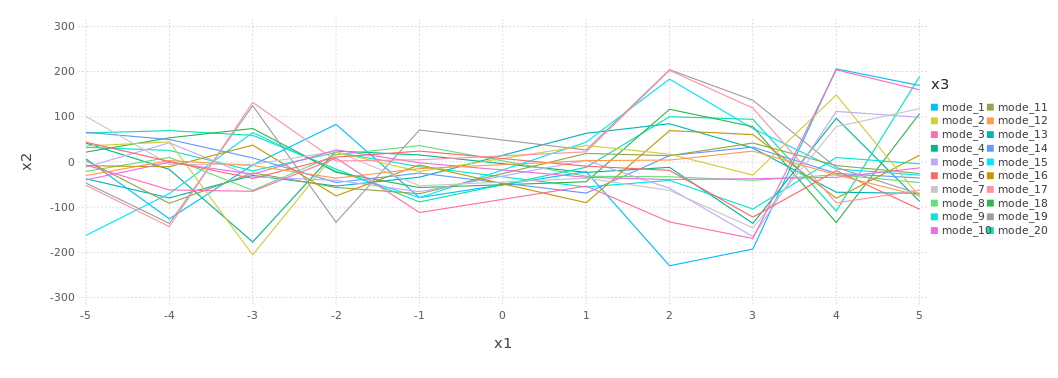

In [148]:
plot(df_label_vol_pocket_mtn_whole_each_mode_03, x="x1", y="x2", color="x3", Geom.line,
Guide.xticks(ticks = collect(-5:1:5)))

## Ahora, c/ modo por separado

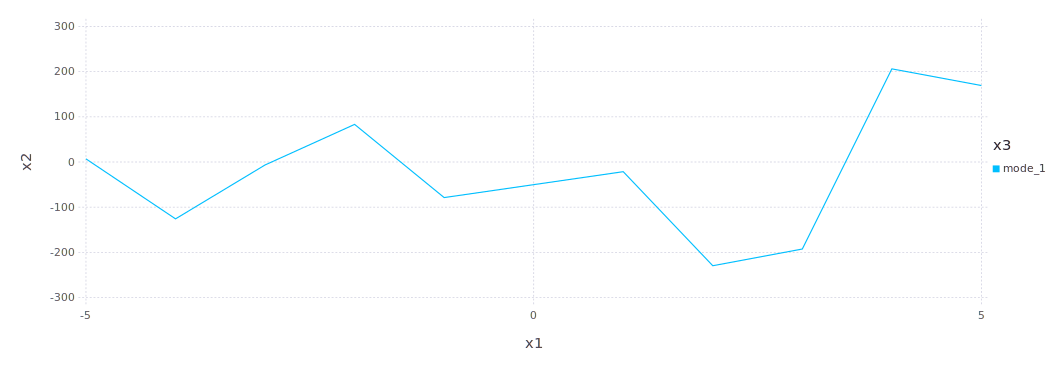

In [88]:
df_label_vol_pocket_mtn_whole_mode_03_1 = df_label_vol_pocket_mtn_whole_each_mode_03[1:10, :]
plot(df_label_vol_pocket_mtn_whole_mode_03_1, x="x1", y="x2", color="x3", Geom.line)

## ANA config: min_vol_radius = 0.5

In [155]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_whole = Array{Float64}(20);
vol_pocket_mtn_whole_ = Array{Float64}(20)
vol_pocket_mtn_whole_each_mode = Array{Float64, 2}(0, 1);

# Ahora calculo los vectores
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude_)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    # Meta?
    global vec_gdte_whole = symbol("gdte_whole_", displacement)
    
    out_gdte_corto = string("gdte_whole_", magnitude)
    for j=1:20
        pdb_mtn = string(files_template, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_05`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_whole = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_05`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_whole = (vol_pocket_mtn_whole .- orig_vol_pocket_mtn_whole)
    
    # Meta?
    @eval ($vec_gdte_whole = $vec_pocket_mtn_whole)           
    
    # Store everything in a matrix
    vol_pocket_mtn_whole_each_mode = vcat(vol_pocket_mtn_whole_each_mode, vec_pocket_mtn_whole)
end
label_vol_pocket_mtn_whole_each_mode_05 = hcat(repeat([-5; -4; -3; -2; -1; 1; 2; 3; 4; 5], outer = [20]),
vol_pocket_mtn_whole_each_mode, repeat(["mode_1"; "mode_2"; "mode_3"; "mode_4"; "mode_5";
    "mode_6"; "mode_7"; "mode_8"; "mode_9"; "mode_10"; "mode_11"; "mode_12"; "mode_13"; "mode_14";
     "mode_15"; "mode_16"; "mode_17"; "mode_18"; "mode_19"; "mode_20"],
inner = [10]))
df_label_vol_pocket_mtn_whole_each_mode_05 = DataFrame(label_vol_pocket_mtn_whole_each_mode_05);

## Cambio de volumen con desplazamientos de -5 a 5, p/ modos 1 a 10

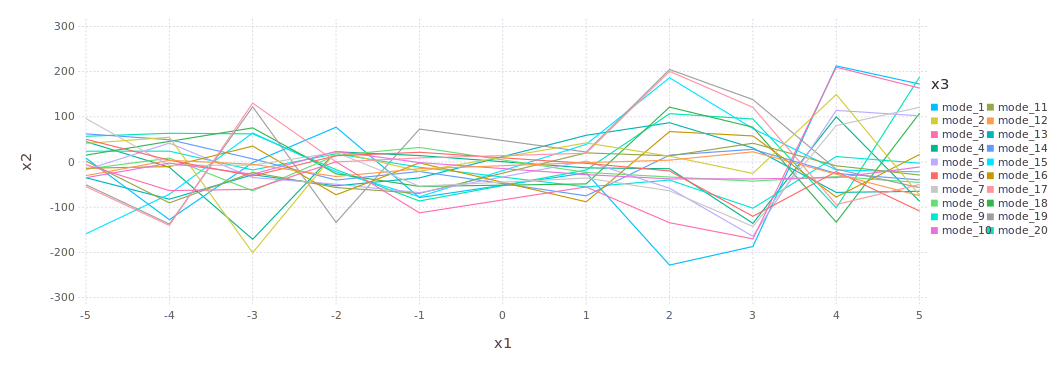

In [156]:
plot(df_label_vol_pocket_mtn_whole_each_mode_05, x="x1", y="x2", color="x3", Geom.line,
Guide.xticks(ticks = collect(-5:1:5)))

## Ahora, c/ modo por separado

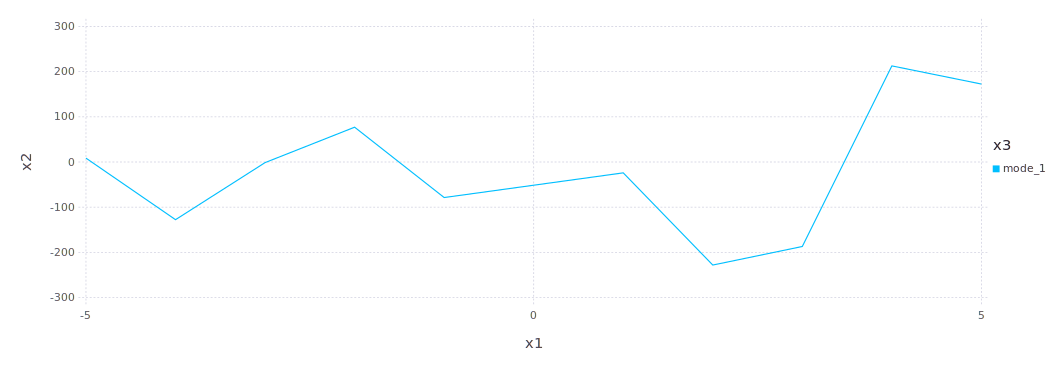

In [91]:
df_label_vol_pocket_mtn_whole_mode_05_1 = df_label_vol_pocket_mtn_whole_each_mode_05[1:10, :]
plot(df_label_vol_pocket_mtn_whole_mode_05_1, x="x1", y="x2", color="x3", Geom.line)

## ANA config: min_vol_radius = 0.8

In [153]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_whole = Array{Float64}(20);
vol_pocket_mtn_whole_ = Array{Float64}(20)
vol_pocket_mtn_whole_each_mode = Array{Float64, 2}(0, 1);

# Ahora calculo los vectores
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude_)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    # Meta?
    global vec_gdte_whole = symbol("gdte_whole_", displacement)
    
    out_gdte_corto = string("gdte_whole_", magnitude)
    for j=1:20
        pdb_mtn = string(files_template, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_08`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_whole = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_08`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_whole = (vol_pocket_mtn_whole .- orig_vol_pocket_mtn_whole)
    
    # Meta?
    @eval ($vec_gdte_whole = $vec_pocket_mtn_whole)           
    
    # Store everything in a matrix
    vol_pocket_mtn_whole_each_mode = vcat(vol_pocket_mtn_whole_each_mode, vec_pocket_mtn_whole)
end
label_vol_pocket_mtn_whole_each_mode_08 = hcat(repeat([-5; -4; -3; -2; -1; 1; 2; 3; 4; 5], outer = [20]),
vol_pocket_mtn_whole_each_mode, repeat(["mode_1"; "mode_2"; "mode_3"; "mode_4"; "mode_5";
    "mode_6"; "mode_7"; "mode_8"; "mode_9"; "mode_10"; "mode_11"; "mode_12"; "mode_13"; "mode_14";
     "mode_15"; "mode_16"; "mode_17"; "mode_18"; "mode_19"; "mode_20"],
inner = [10]))
df_label_vol_pocket_mtn_whole_each_mode_08 = DataFrame(label_vol_pocket_mtn_whole_each_mode_08);

## Cambio de volumen con desplazamientos de -5 a 5, p/ modos 1 a 10

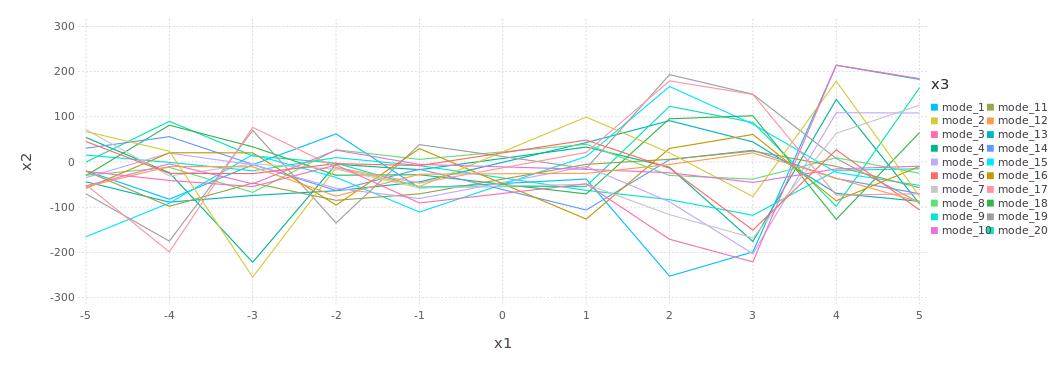

In [154]:
plot(df_label_vol_pocket_mtn_whole_each_mode_08, x="x1", y="x2", color="x3", Geom.line,
Guide.xticks(ticks = collect(-5:1:5)))

## Ahora, c/ modo por separado

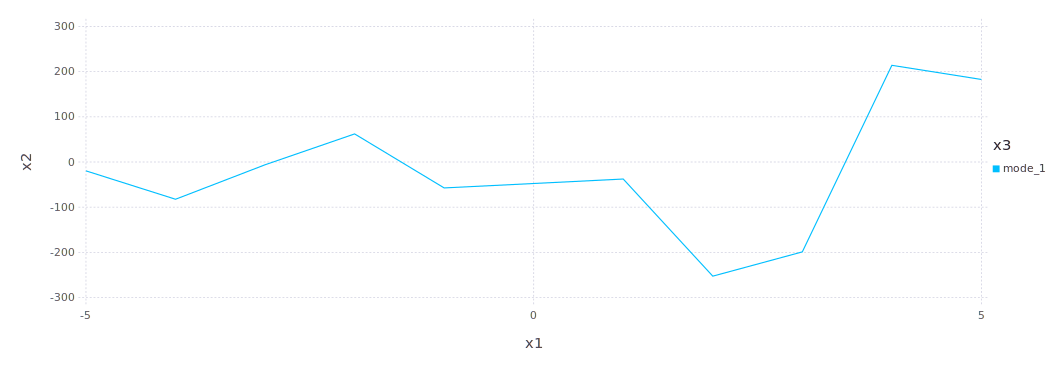

In [131]:
df_label_vol_pocket_mtn_whole_mode_08_1 = df_label_vol_pocket_mtn_whole_each_mode_08[1:10, :]
plot(df_label_vol_pocket_mtn_whole_mode_08_1, x="x1", y="x2", color="x3", Geom.line)

## ANA config: min_vol_radius = 1.0

In [159]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_whole = Array{Float64}(20);
vol_pocket_mtn_whole_ = Array{Float64}(20)
vol_pocket_mtn_whole_each_mode = Array{Float64, 2}(0, 1);

# Ahora calculo los vectores
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude_)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    # Meta?
    global vec_gdte_whole = symbol("gdte_whole_", displacement)
    
    out_gdte_corto = string("gdte_whole_", magnitude)
    for j=1:20
        pdb_mtn = string(files_template, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_1`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_whole = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_1`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_whole = (vol_pocket_mtn_whole .- orig_vol_pocket_mtn_whole)
    
    # Meta?
    @eval ($vec_gdte_whole = $vec_pocket_mtn_whole)           
    
    # Store everything in a matrix
    vol_pocket_mtn_whole_each_mode = vcat(vol_pocket_mtn_whole_each_mode, vec_pocket_mtn_whole)
end
label_vol_pocket_mtn_whole_each_mode_1 = hcat(repeat([-5; -4; -3; -2; -1; 1; 2; 3; 4; 5], outer = [20]),
vol_pocket_mtn_whole_each_mode, repeat(["mode_1"; "mode_2"; "mode_3"; "mode_4"; "mode_5";
    "mode_6"; "mode_7"; "mode_8"; "mode_9"; "mode_10"; "mode_11"; "mode_12"; "mode_13"; "mode_14";
     "mode_15"; "mode_16"; "mode_17"; "mode_18"; "mode_19"; "mode_20"],
inner = [10]))
df_label_vol_pocket_mtn_whole_each_mode_1 = DataFrame(label_vol_pocket_mtn_whole_each_mode_1);

## Cambio de volumen con desplazamientos de -5 a 5, p/ modos 1 a 10

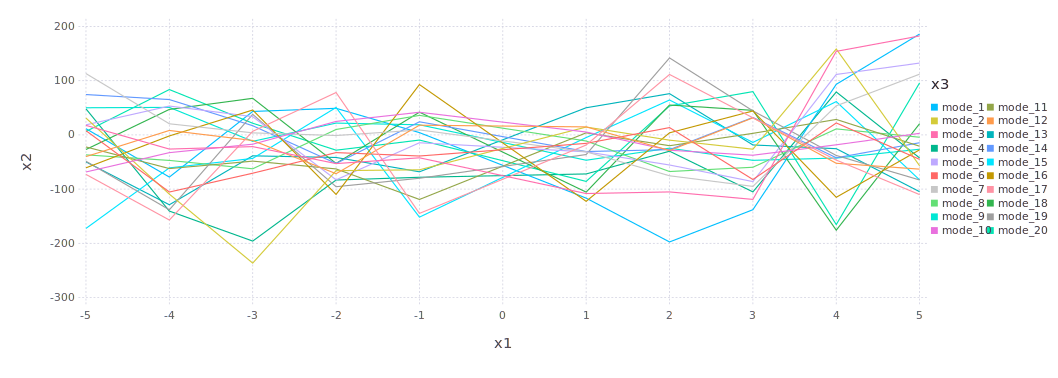

In [160]:
plot(df_label_vol_pocket_mtn_whole_each_mode_1, x="x1", y="x2", color="x3", Geom.line,
Guide.xticks(ticks = collect(-5:1:5)))

## Ahora, c/ modo por separado

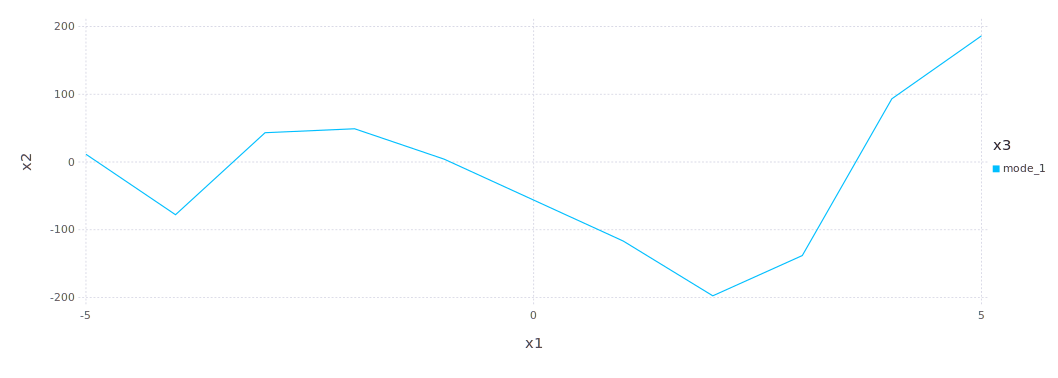

In [130]:
df_label_vol_pocket_mtn_whole_mode_1_1 = df_label_vol_pocket_mtn_whole_each_mode_1[1:10, :]
plot(df_label_vol_pocket_mtn_whole_mode_1_1, x="x1", y="x2", color="x3", Geom.line)

## ANA config: min_vol_radius = 1.3

In [163]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_whole = Array{Float64}(20);
vol_pocket_mtn_whole_ = Array{Float64}(20)
vol_pocket_mtn_whole_each_mode = Array{Float64, 2}(0, 1);

# Ahora calculo los vectores
for magnitude in [-5 -4 -3 -2 -1 1 2 3 4 5]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude_)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    # Meta?
    global vec_gdte_whole = symbol("gdte_whole_", displacement)
    
    out_gdte_corto = string("gdte_whole_", magnitude)
    for j=1:20
        pdb_mtn = string(files_template, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_13`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_whole = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole_13`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_whole = (vol_pocket_mtn_whole .- orig_vol_pocket_mtn_whole)
    
    # Meta?
    @eval ($vec_gdte_whole = $vec_pocket_mtn_whole)           
    
    # Store everything in a matrix
    vol_pocket_mtn_whole_each_mode = vcat(vol_pocket_mtn_whole_each_mode, vec_pocket_mtn_whole)
end
label_vol_pocket_mtn_whole_each_mode_13 = hcat(repeat([-5; -4; -3; -2; -1; 1; 2; 3; 4; 5], outer = [20]),
vol_pocket_mtn_whole_each_mode, repeat(["mode_1"; "mode_2"; "mode_3"; "mode_4"; "mode_5";
    "mode_6"; "mode_7"; "mode_8"; "mode_9"; "mode_10"; "mode_11"; "mode_12"; "mode_13"; "mode_14";
     "mode_15"; "mode_16"; "mode_17"; "mode_18"; "mode_19"; "mode_20"],
inner = [10]))
df_label_vol_pocket_mtn_whole_each_mode_13 = DataFrame(label_vol_pocket_mtn_whole_each_mode_13);

## Cambio de volumen con desplazamientos de -5 a 5, p/ modos 1 a 10

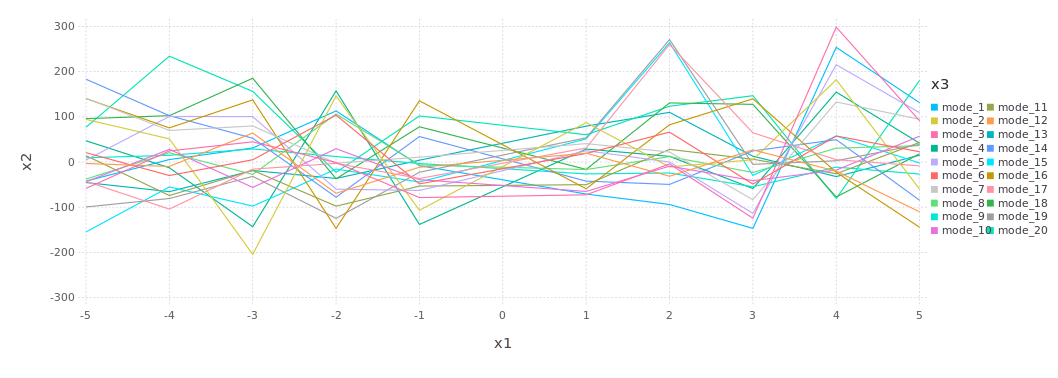

In [165]:
plot(df_label_vol_pocket_mtn_whole_each_mode_13, x="x1", y="x2", color="x3", Geom.line,
Guide.xticks(ticks = collect(-5:1:5)))

## Ahora, c/ modo por separado

In [170]:
df_label_vol_pocket_mtn_whole_mode_13_1 = df_label_vol_pocket_mtn_whole_each_mode_13[1:10, :]
df_label_vol_pocket_mtn_whole_mode_13_2 = df_label_vol_pocket_mtn_whole_each_mode_13[11:20, :]
df_label_vol_pocket_mtn_whole_mode_13_3 = df_label_vol_pocket_mtn_whole_each_mode_13[21:30, :]
df_label_vol_pocket_mtn_whole_mode_13_4 = df_label_vol_pocket_mtn_whole_each_mode_13[31:40, :]
df_label_vol_pocket_mtn_whole_mode_13_5 = df_label_vol_pocket_mtn_whole_each_mode_13[41:50, :]
df_label_vol_pocket_mtn_whole_mode_13_6 = df_label_vol_pocket_mtn_whole_each_mode_13[51:60, :]
df_label_vol_pocket_mtn_whole_mode_13_7 = df_label_vol_pocket_mtn_whole_each_mode_13[61:70, :]
df_label_vol_pocket_mtn_whole_mode_13_8 = df_label_vol_pocket_mtn_whole_each_mode_13[71:80, :]
df_label_vol_pocket_mtn_whole_mode_13_9 = df_label_vol_pocket_mtn_whole_each_mode_13[81:90, :]
df_label_vol_pocket_mtn_whole_mode_13_10 = df_label_vol_pocket_mtn_whole_each_mode_13[91:100, :];

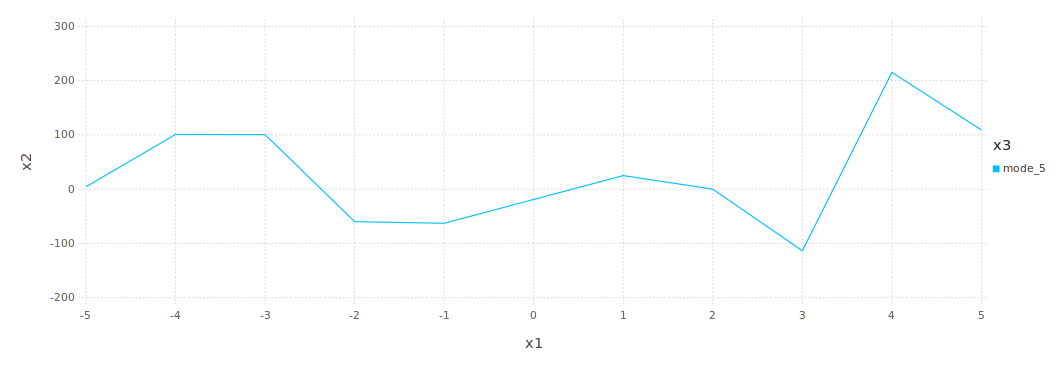

In [172]:
plot(df_label_vol_pocket_mtn_whole_mode_13_5, x="x1", y="x2", color="x3", Geom.line,
Guide.xticks(ticks = collect(-5:1:5)))

## Todo junto

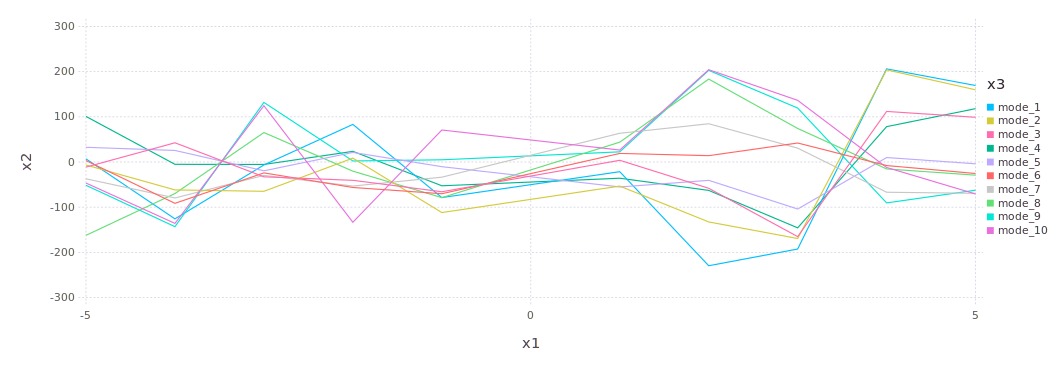

In [103]:
plot(df_label_vol_pocket_mtn_whole_each_mode_03, x="x1", y="x2", color="x3", Geom.line)

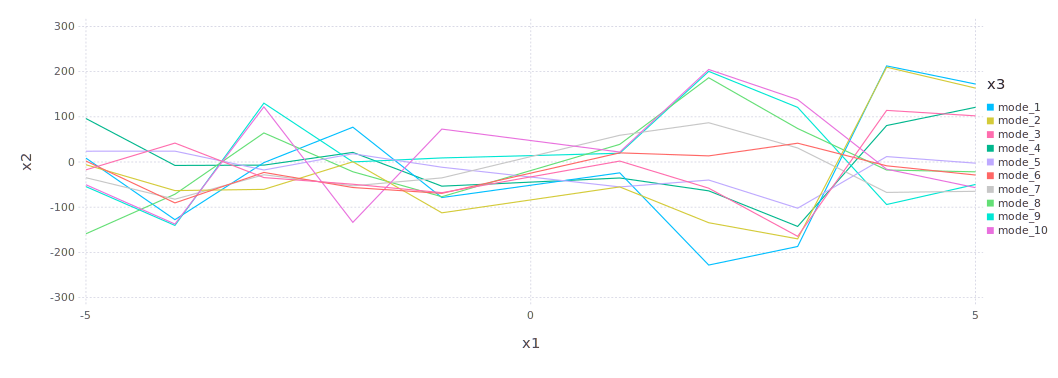

In [104]:
plot(df_label_vol_pocket_mtn_whole_each_mode_05, x="x1", y="x2", color="x3", Geom.line)

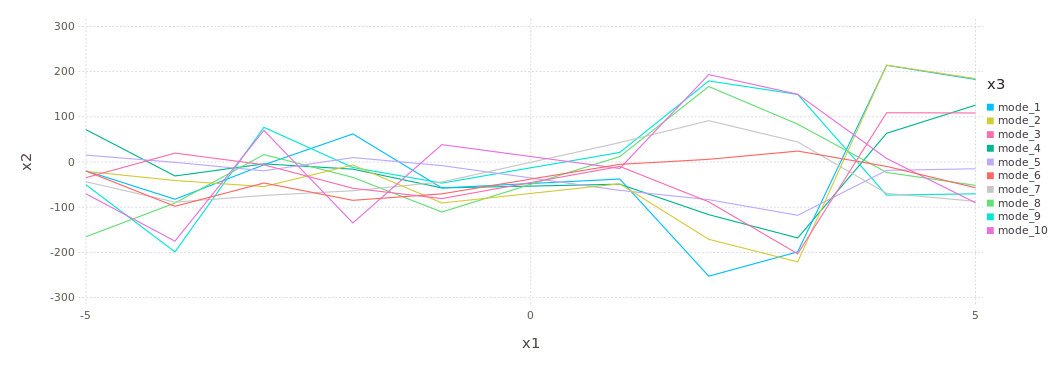

In [105]:
plot(df_label_vol_pocket_mtn_whole_each_mode_08, x="x1", y="x2", color="x3", Geom.line)

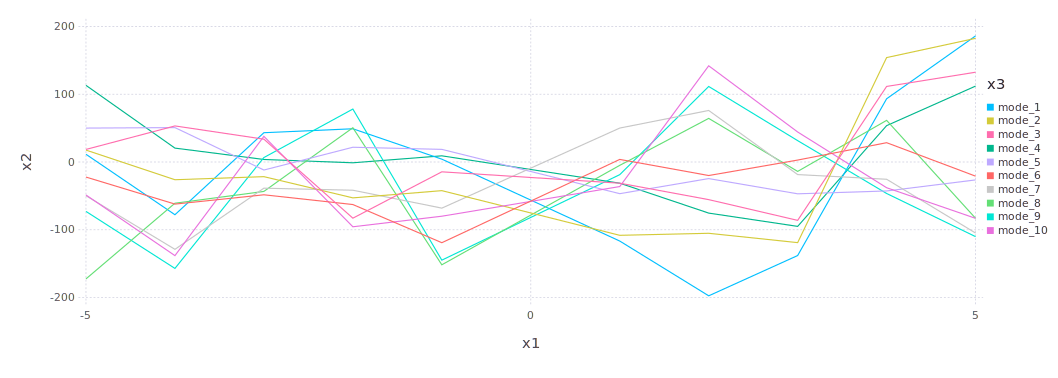

In [122]:
plot(df_label_vol_pocket_mtn_whole_each_mode_1, x="x1", y="x2", color="x3", Geom.line)

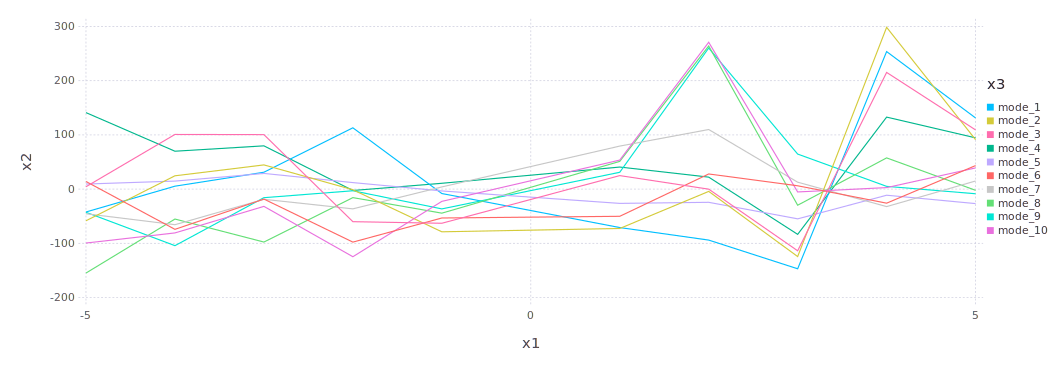

In [123]:
plot(df_label_vol_pocket_mtn_whole_each_mode_13, x="x1", y="x2", color="x3", Geom.line)

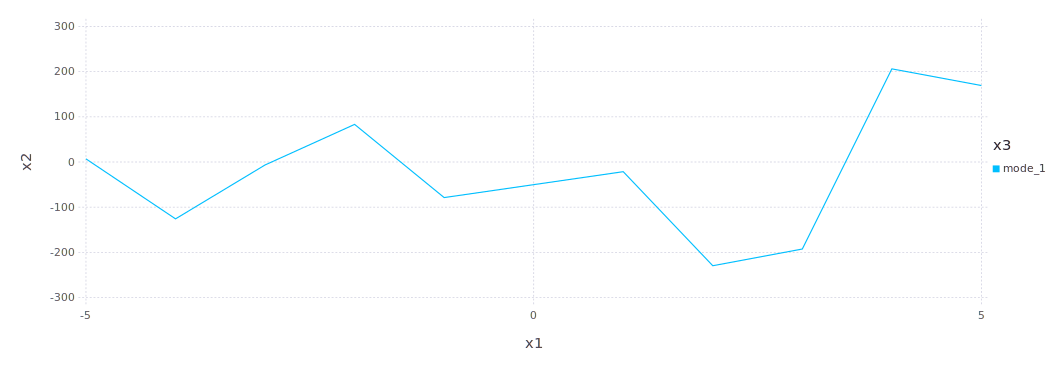

In [138]:
plot(df_label_vol_pocket_mtn_whole_mode_03_1, x="x1", y="x2", color="x3", Geom.line)

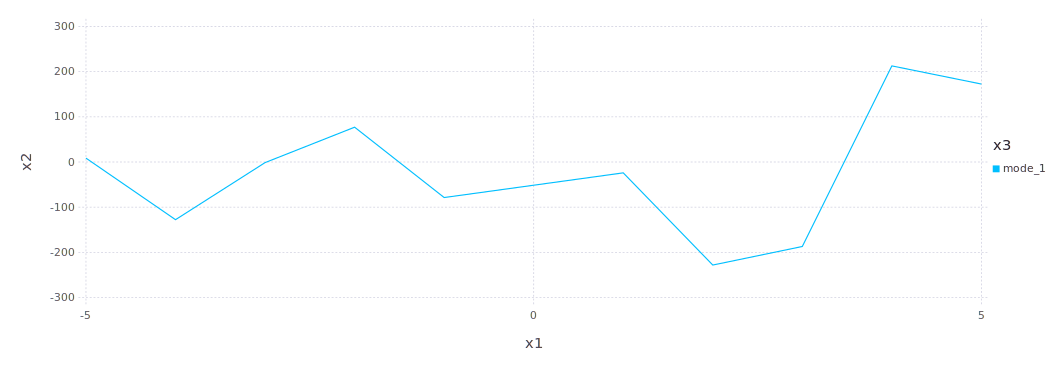

In [137]:
plot(df_label_vol_pocket_mtn_whole_mode_05_1, x="x1", y="x2", color="x3", Geom.line)

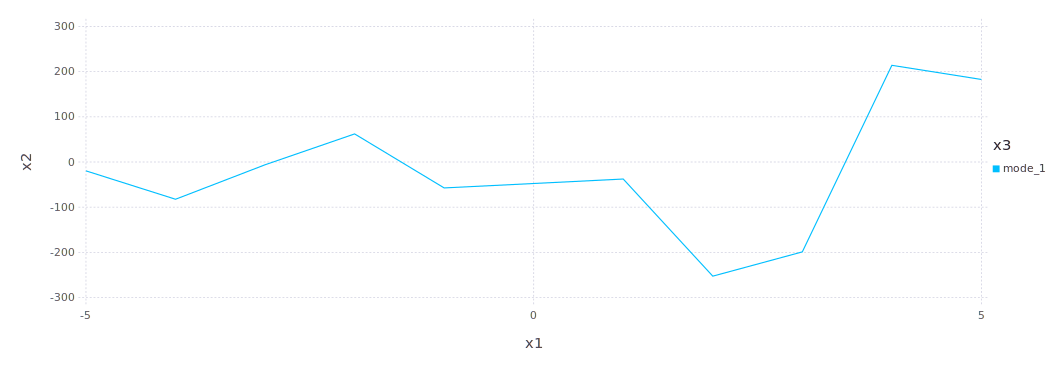

In [136]:
plot(df_label_vol_pocket_mtn_whole_mode_08_1, x="x1", y="x2", color="x3", Geom.line)

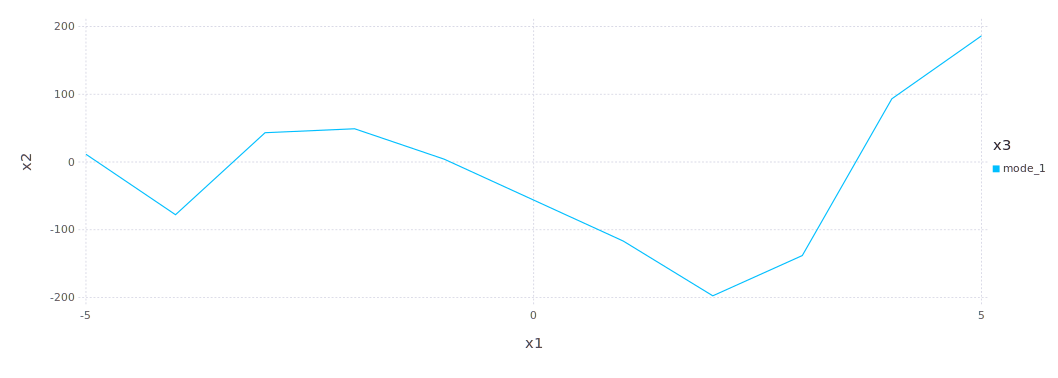

In [134]:
plot(df_label_vol_pocket_mtn_whole_mode_1_1, x="x1", y="x2", color="x3", Geom.line)

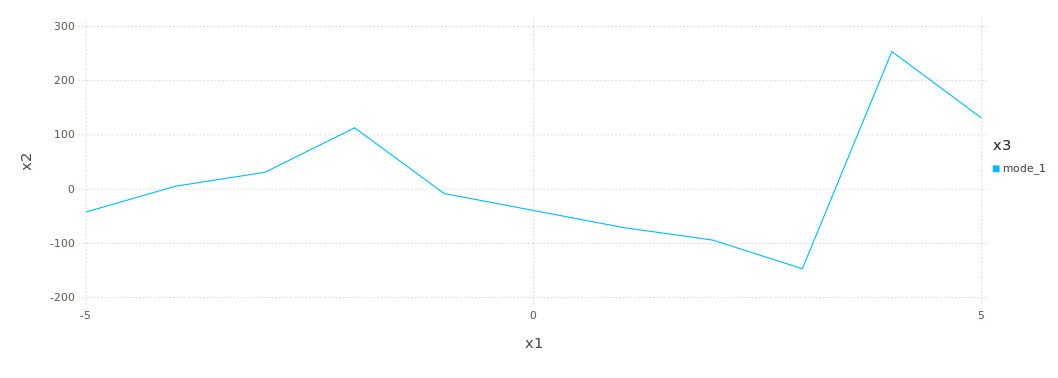

In [135]:
plot(df_label_vol_pocket_mtn_whole_mode_13_1, x="x1", y="x2", color="x3", Geom.line)